# Estimating the correlation length 

* A central parameter for the `DIVAnd` analysis is the correlation length.
* It determines whether two points separated by a given distance are correlated or not.
* `DIVAnd` includes several tools to estimate the correlation length.
* We will start with a 2D case and consider the 3D case.
* This notebook can run on multiple CPU threads (see `01-notebooks-basics.ipynb`)

In [1]:
using DIVAnd
using PyPlot
using Dates
using Statistics
using Random
using Printf

# Data reading

The file `WOD-Salinity-Provencal.nc` contains salinity measurement obtained from the World Ocean Database for the Provençal Basin (Mediterranean Sea). The profiles were not interpolated vertically. It is based on the [World Ocean Database](https://www.nodc.noaa.gov/OC5/WOD/pr_wod.html).

The resulting correlation length can fluctuate a bit because the correlation is based on a collection of random pairs. 

## 2D case

* First lets consider only the data on a 2D surface (longitude and latitude)
* Load the data file if it is not already present.

In [2]:
varname = "Salinity"
filename = "../data/WOD-Salinity-Provencal.nc"

if !isfile(filename)    
    download("https://dox.ulg.ac.be/index.php/s/PztJfSEnc8Cr3XN/download",filename)
else
    @info("Data file $filename already downloaded")
end


bathname = "../data/gebco_30sec_4.nc"
if !isfile(bathname)
    download("https://dox.ulg.ac.be/index.php/s/U0pqyXhcQrXjEUX/download",bathname)
else
    @info("Bathymetry file already downloaded")
end
lonr = 3.:0.1:11.8
latr = 42.:0.1:44.5
bathisglobal = true
# Extract the bathymetry for plotting
bx,by,b = extract_bath(bathname,bathisglobal,lonr,latr);

┌ Info: Data file ../data/WOD-Salinity-Provencal.nc already downloaded
└ @ Main In[2]:7
┌ Info: Bathymetry file already downloaded
└ @ Main In[2]:15


Load the data and print basic information about it that can be used for quality check.

In [3]:
obsval,obslon,obslat,obsdepth,obstime,obsid = loadobs(Float64,filename,"Salinity")
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

              minimum and maximum of obs. dimension 1: (

┌ Info: Checking ranges for dimensions and observations
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/obsstat.jl:75


3.0418334007263184, 11.8100004196167)
              minimum and maximum of obs. dimension 2: (42.0, 44.0)
              minimum and maximum of obs. dimension 3: (-0.0, 2762.0)
              minimum and maximum of obs. dimension 4: (1892-09-25T00:00:00, 2017-10-02T06:14:02.761)
                          minimum and maximum of data: (0.25, 40.0)


It is quite important to remove outliers for the correlation length estimation, as outlires can have a significant impact.

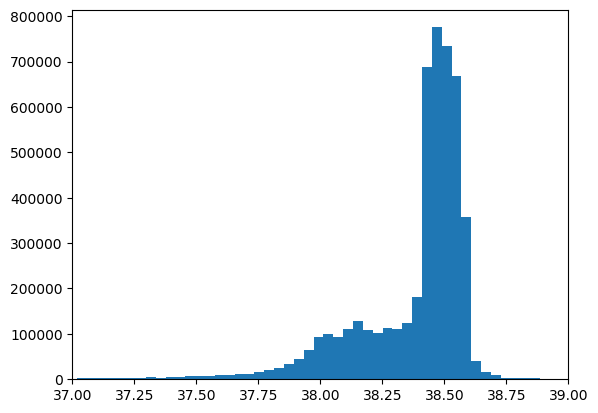

(37, 39)

In [4]:
hist(obsval,1000)
xlim(37,39)

For this example we select only the first month (January) and we remove some questionable data

In [5]:
badid = ["wod_015600782O","wod_015602753O","wod_015604717O","wod_015606732O","wod_015607117O","wod_015607524O","wod_015607893O","wod_015924970O","wod_015926914O","wod_015928739O","wod_016650545O", "wod_008518725O","wod_007643915O","wod_015875365O","wod_006614816O","wod_006614929O","wod_006614937O","wod_007644875O","wod_009996947O","wod_010742471O","wod_010742472O","wod_006614931O","wod_006614934O","wod_006625408O","wod_006752127O","wod_006752129O"]
good = (37.6 .< obsval .< 38.75) .& map(id -> !(id in badid),obsid)


sel = (Dates.month.(obstime) .== 1) .& good
x = (obslon[sel],obslat[sel],obsdepth[sel]);
v = obsval[sel]

z = [0.,5., 10., 15., 20., 25., 30., 40., 50., 66, 
    75, 85, 100, 112, 125, 135, 150, 175, 200, 225, 250, 
    275, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 
    800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 
    1300, 1350, 1400, 1450, 1500, 1600, 1750, 1850, 2000]

#z = [0.,5., 10., 15., 20., 25., 30., 40., 50., 66, 
#    75, 85, 100, 112, 125, 135, 150, 175, 200, 225, 250, 
#    275, 300, 350, 400, 450, 500, 550, 600];


Plot the observation at a given level. What do you think will happend if you run `plotobs.(z)`?

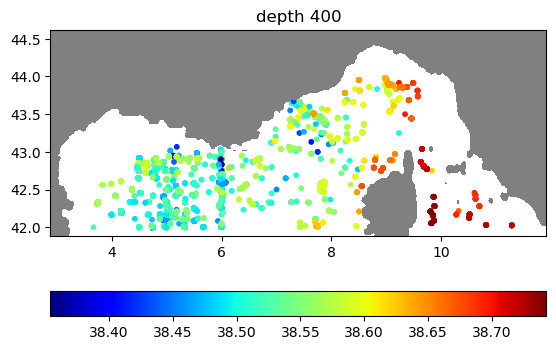

In [6]:
function plotobs(z)
    figure()
    sel = (Dates.month.(obstime) .== 1) .& (abs.(obsdepth .- z) .< 50)  .& good # .& (obsval .< 38.3)
    scatter(obslon[sel],obslat[sel],10,obsval[sel], cmap="jet"); colorbar(orientation = "horizontal");
    #print(join(map(s -> '"' * s * '"',String.(unique(obsid[sel]))),","))
    contourf(bx,by,b', levels = [-1e5,0],colors = [[.5,.5,.5]])
    aspectratio = 1/cos(mean(latr) * pi/180)
    gca().set_aspect(aspectratio)
    title("depth $z")
end
plotobs(400);

### Horizontal correlation length
Estimate the horizontal correlation length for different depth levels    
(can take a few minutes).

In [7]:
@time lenxy,infoxy = fithorzlen(x,v,z; distfun = DIVAnd.distfun_m, searchz = z -> (z/4+10));

┌ Info: Data points at z=0.0: 3365, horz. correlation length: 16666.258916439838 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1081
┌ Info: Data points at z=5.0: 5739, horz. correlation length: 16764.154402248707 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1081
┌ Info: Data points at z=10.0: 8072, horz. correlation length: 16047.193003508934 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1081
┌ Info: Data points at z=15.0: 9573, horz. correlation length: 17226.761631744557 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1081
┌ Info: Data points at z=20.0: 10929, horz. correlation length: 17647.18150405224 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1081
┌ Info: Data points at z=25.0: 11921, horz. correlation length: 17166.58759097617 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1081
┌ Info: Data points at z=30.0: 12284

┌ Info: Data points at z=1850.0: 34256, horz. correlation length: 15353.108761130063 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1081
┌ Warning: Too few data. Will use guesses (np = 9, RLz = 15408.006995212763, )
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:895
┌ Info: Data points at z=2000.0: 29559, horz. correlation length: 15408.006995212763 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1081
┌ Info: Smoothed horz. correlation length at z=0.0: 14471.538167494806
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1109
┌ Info: Smoothed horz. correlation length at z=5.0: 14465.534278051377
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1109
┌ Info: Smoothed horz. correlation length at z=10.0: 14453.598157061946
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1109
┌ Info: Smoothed horz. correlation length at z=15.0: 14435.873518652817
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl

148.756205 seconds (2.53 G allocations: 75.698 GiB, 7.02% gc time)


Information about the fitting:


In [8]:
infoxy[:fitinfos][1]

Dict{Symbol,Any} with 8 entries:
  :sn          => 0.582371
  :rqual       => 0.90374
  :fitcovar    => [NaN, 0.0106974, 0.0102033, 0.00959847, 0.0089442, 0.00827595…
  :meandist    => 1.74699e5
  :covar       => [0.0145739, 0.0122097, 0.00966681, 0.00827608, 0.00766433, 0.…
  :range       => 2:23
  :distx       => 0.0:2183.7341347536476:705346.1255254282
  :covarweight => [1.07905e15, 1.07904e15, 1.07926e15, 1.07909e15, 1.07904e15, …

Extract the information for the level `k = 1`:
* `covar`: the empirical covariance
* `fitcovar`: the fitted empirical covariance
* `distx`: distance
* `range`: part of `covar` used for the fitting
* `rqual`: the quality for the fit (1: excellent, 0: poor)

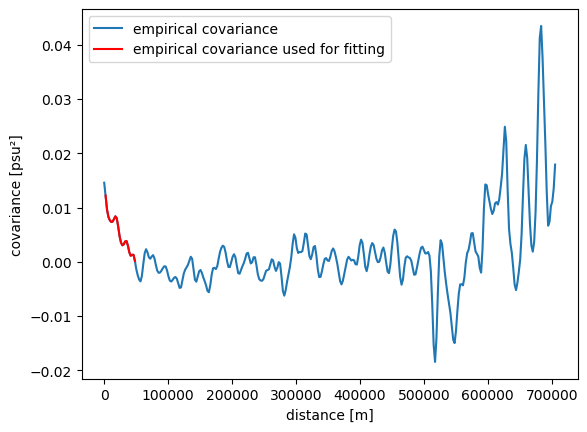

In [9]:
k = 1
covar = infoxy[:fitinfos][k][:covar]
fitcovar = infoxy[:fitinfos][k][:fitcovar]
distx = infoxy[:fitinfos][k][:distx]
range = infoxy[:fitinfos][k][:range]
rqual = infoxy[:fitinfos][k][:rqual]

plot(distx,covar,label="empirical covariance")
plot(distx[range],covar[range],"r",label="empirical covariance used for fitting")
ylabel("covariance [psu²]")
xlabel("distance [m]")
legend();

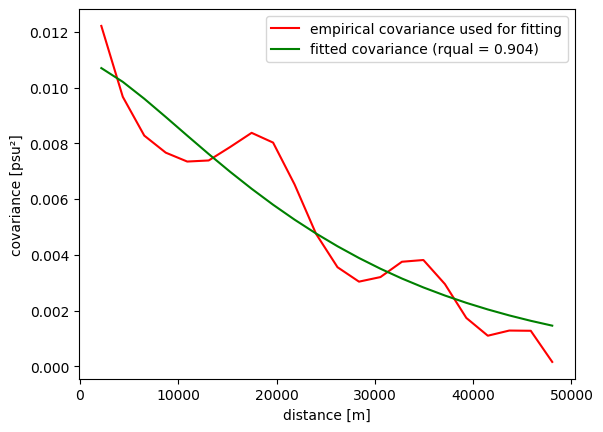

In [10]:
plot(distx[range],covar[range],"r",label="empirical covariance used for fitting")
plot(distx[range],fitcovar[range],"g",label="fitted covariance (rqual = $(@sprintf("%4.3f",rqual)))")
ylabel("covariance [psu²]")
xlabel("distance [m]")
legend();

Try different values of k (the level index) and rerun the previous two cells. Note that at some level the fit was quite poor. Additional filtering (vertically) is done to smooth the horizontal correlation length.


Make a plot of the horizontal correlation length with respect to the depth. 

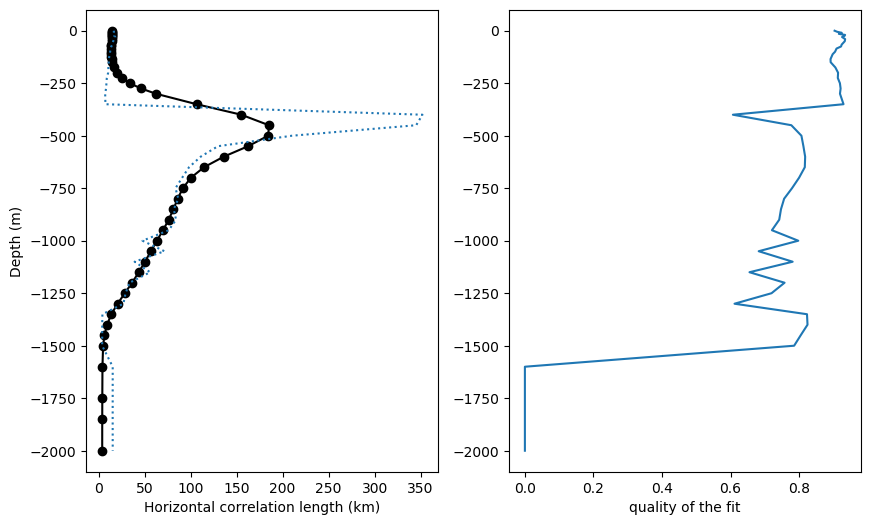

In [11]:
rqual = [f[:rqual] for f in infoxy[:fitinfos]]
figure(figsize = (10,6))
subplot(1,2,1)
plot(lenxy/1000,-z, "ko-")
plot(infoxy[:len]/1000,-z,":");
xlabel("Horizontal correlation length (km)")
ylabel("Depth (m)")
#xlim(0,180)
subplot(1,2,2)
plot(rqual,-z)
xlabel("quality of the fit");

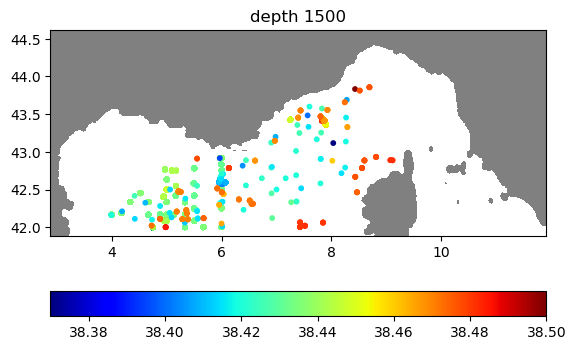

In [12]:
plotobs(1500);

It is useful to limit the acceptable range of the correlation length by providing a function `limitfun` with the argument depth `z` and estimated correlation length `len`. It the returns the adjusted correlation length. This adjustememt is done before the filtering.

In [13]:
@time lenxy2,infoxy2 = fithorzlen(x,v,z; distfun = DIVAnd.distfun_m, limitfun = (z,len) -> min(max(len,25e3),60e3));


┌ Info: Data points at z=0.0: 17698, horz. correlation length: 16644.774748761425 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1081
┌ Info: Data points at z=5.0: 19460, horz. correlation length: 16455.17753263328 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1081
┌ Info: Data points at z=10.0: 21024, horz. correlation length: 16356.935657698754 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1081
┌ Info: Data points at z=15.0: 22717, horz. correlation length: 16385.964473483953 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1081
┌ Info: Data points at z=20.0: 24290, horz. correlation length: 16372.19548517319 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1081
┌ Info: Data points at z=25.0: 26100, horz. correlation length: 16182.012677273116 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1081
┌ Info: Data points at z=30.0: 2

┌ Info: Data points at z=1850.0: 4012, horz. correlation length: 13957.960520523642 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1081
┌ Warning: Too few data. Will use guesses (np = 8, RLz = 13663.53843353751, )
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:895


139.993404 seconds (2.48 G allocations: 74.012 GiB, 7.32% gc time)


┌ Info: Data points at z=2000.0: 3246, horz. correlation length: 13663.53843353751 (preliminary)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1081
┌ Info: Smoothed horz. correlation length at z=0.0: 25005.90173701728
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1109
┌ Info: Smoothed horz. correlation length at z=5.0: 25006.097350455806
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1109
┌ Info: Smoothed horz. correlation length at z=10.0: 25006.493428685575
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1109
┌ Info: Smoothed horz. correlation length at z=15.0: 25007.09974844648
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1109
┌ Info: Smoothed horz. correlation length at z=20.0: 25007.931160150085
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1109
┌ Info: Smoothed horz. correlation length at z=25.0: 25009.007810838335
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1109
┌ Info: Smoothed hor

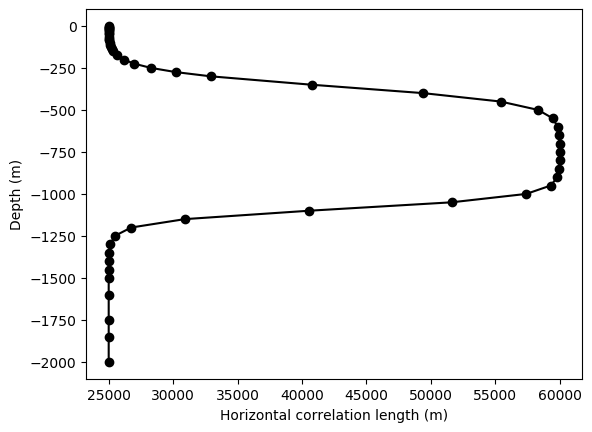

In [14]:
plot(lenxy2,-z, "ko-")
#plot(infoxy2[:len],-z,":");
xlabel("Horizontal correlation length (m)")
ylabel("Depth (m)");



### Vertical correlation length 
The vertical correlation length is also estimated for different depth levels

In [20]:
lenz,infoz = fitvertlen(x,v,z);

┌ Info: Vert. correlation length at z=0.0: 53.28
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1177
┌ Info: Vert. correlation length at z=5.0: 55.02297600000001
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1177
┌ Info: Vert. correlation length at z=10.0: 51.940944
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1177
┌ Info: Vert. correlation length at z=15.0: 50.651721549316406
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1177
┌ Warning: Too few data. Will use guesses (np = 9, RLz = 202.07999999999998, )
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:895
┌ Info: Vert. correlation length at z=20.0: 202.07999999999998
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1177
┌ Info: Vert. correlation length at z=25.0: 48.098688
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit.jl:1177
┌ Warning: Too few data. Will use guesses (np = 9, RLz = 197.68, )
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/fit

Make a plot

In [21]:
infoz

Dict{Symbol,Array{T,1} where T} with 3 entries:
  :fitinfos => Dict{Symbol,Any}[Dict(:sn=>10000.0,:rqual=>0.683668,:fitcovar=>[…
  :len      => [53.28, 55.023, 51.9409, 50.6517, 202.08, 48.0987, 197.68, 184.1…
  :var0     => [0.0203519, 0.0203519, 0.0203519, 0.0203519, 0.0201484, 0.020351…

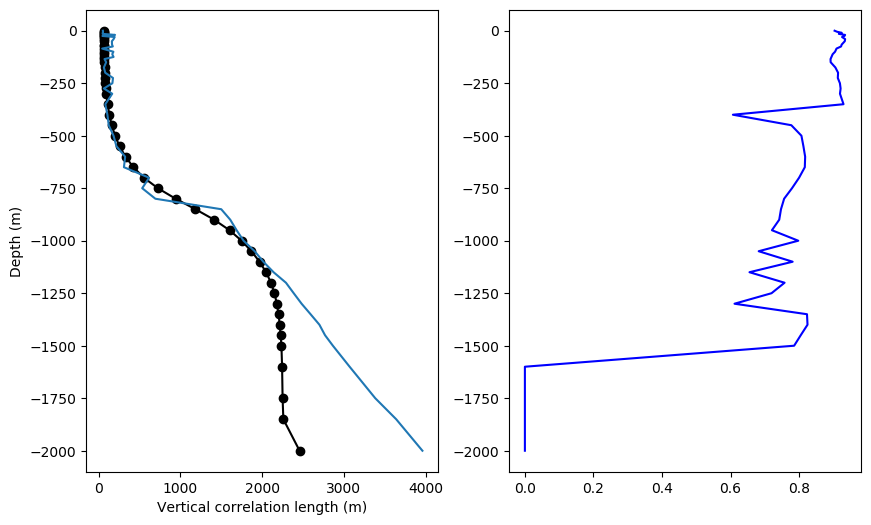

In [25]:
rqual = [f[:rqual] for f in infoxy[:fitinfos]]
figure(figsize = (10,6))
subplot(1,2,1)
plot(lenz,-z, "ko-")
plot(infoz[:len],-z, "-")
xlabel("Vertical correlation length (m)")
ylabel("Depth (m)");

subplot(1,2,2)
plot(rqual,-z, "b-");

An alternative is to use of the vertical coordinate to obtain a reasonable guess of the vertical correlation

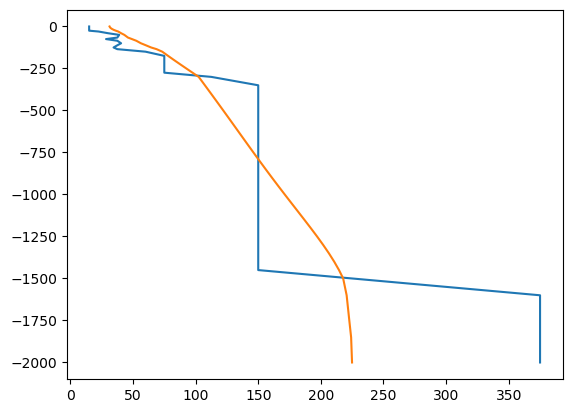

In [26]:
Dz = (z[3:end] - z[1:end-2])/2
lenz = 3 * [Dz[1], Dz..., Dz[end]]
lenzf = DIVAnd.smoothfilter(1:length(lenz),lenz,10)
plot(lenz,-z)
plot(lenzf,-z);